## Imports

In [6]:
import pandas as pd
import seaborn as sns
import optuna
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC

from sklearn.ensemble import (
    AdaBoostClassifier, 
    BaggingClassifier, 
    ExtraTreesClassifier, 
    RandomForestClassifier, 
    StackingClassifier, 
    GradientBoostingClassifier, 
    HistGradientBoostingClassifier,
    VotingClassifier
)

from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    SGDClassifier,
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

from sklearn.neural_network import MLPClassifier


## Configs

In [7]:
TRAIN_PATH = "https://raw.githubusercontent.com/claytonsilva007/IDP/refs/heads/main/ml-01/dados/titanic/train.csv"
TEST_PATH = "https://raw.githubusercontent.com/claytonsilva007/IDP/refs/heads/main/ml-01/dados/titanic/test.csv"

pd.set_option('display.max_rows', 900)

import warnings
import logging

# Suprimir avisos
warnings.filterwarnings('ignore')

# Configurar logging para minimizar mensagens de output de alguns classificadores
logging.basicConfig(level=logging.ERROR)


# preenchido quando o método set_feature_importance() é chamado
feature_importance_cols = list()

multicolinear_features = list()

def adicionar_caracteristicas_fortemente_correlacionadas(feature: str):
    global multicolinear_features
    multicolinear_features.append(feature) if feature not in multicolinear_features else None


def remover_feature_fortemente_correlacionada(feature: str):
    global multicolinear_features
    multicolinear_features.remove(feature) if feature in multicolinear_features else None

## Functions

In [8]:
def get_dataframe(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

In [9]:
def get_train_and_test_dataframes() -> pd.DataFrame:
    train = get_dataframe(path=TRAIN_PATH)
    test = get_dataframe(path=TEST_PATH)
    df = pd.concat([train, test])
    df = pd.concat([train, test]).reset_index(drop=True)
    return df

In [10]:
get_dataframe(path=TRAIN_PATH).shape

(891, 12)

In [11]:
get_dataframe(path=TEST_PATH).shape

(418, 11)

In [12]:
def plot_heatmap(corr): 
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(15, 12))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, 
                mask=mask, 
                cmap=cmap, 
                vmax=1, 
                center=0,
                square=True, 
                linewidths=.5, 
                cbar_kws={"shrink": .5},
                annot=True, 
                fmt=".2f")
    plt.show()

## EDA

In [13]:
df = get_dataframe(path=TRAIN_PATH)
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are three columns with null values: Age, Cabin and Embarked. We will fill the Age column with the mean age, grouped by Sex and Parch. Cabin and Embarked will process after feature engeniering process.

## Feature Engeniering

Features:
1. Após tratar informações de cabine, verificar pessoas que viajaram na mesma cabine e criar um atributo.

In [15]:
df = get_dataframe(path=TRAIN_PATH)

### Name

In [16]:
def get_pronouns(name) -> str:
    if ", " in name and "." in name:
        return name.split(", ")[1].split(".")[0]
    return "None" 

In [17]:
df['Pronouns'] = df.Name.map(get_pronouns)
df.Pronouns.value_counts()

Pronouns
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

In [18]:
def join_pronouns(df: pd.DataFrame) -> pd.DataFrame:
    df['Pronouns'] = df['Pronouns'].map({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}).fillna(df['Pronouns'])
    df.Pronouns = df['Pronouns'].map({
        'Dr': 'Other', 
        'Rev': 'Other', 
        'Col': 'Other', 
        'Major': 'Other', 
        'Don': 'Other', 
        'Lady': 'Other', 
        'Sir': 'Other', 
        'Capt': 'Other', 
        'the Countess': 'Other', 
        'Jonkheer': 'Other'
    }).fillna(df['Pronouns'])
    
    return df

In [19]:
df = join_pronouns(df)
df.Pronouns.value_counts()

Pronouns
Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: count, dtype: int64

In [20]:
def encoding_pronouns(df: pd.DataFrame) -> pd.DataFrame:
    df.Pronouns = df.Pronouns.map({'Mrs': 5, 'Miss': 4, 'Master': 3, 'Other': 2, 'Mr': 1}).fillna(df.Pronouns)
    # df = pd.get_dummies(data=df, columns=['Pronouns'], dtype=int)
    return df

In [21]:
# Aplicar a função
df = encoding_pronouns(df=df)
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Pronouns  
0      0         A/5 21171   7.2500   NaN        S         1  
1      0          PC 17599  71.2833   C85        C         5  
2      0  STON/O2. 3101282   7.9250   NaN        S         4  
3      0            113803  53.1000  C123        S         5  
4    

In [22]:
def format_name(row) -> str:
    if row.Sex == 'female':
        if "(" in row.Name and ")" in row.Name:
            return row.Name.lower().split("(")[1].split(")")[0].replace('"', '').strip()
        else:
            rname = row.Name.split(". ")[1]
            lname = row.Name.split(", ")[0]
            name = rname + " " + lname
            return name.lower().replace('"', '').strip()
    else:
        rname = row.Name.split(". ")[1]
        lname = row.Name.split(", ")[0]
        name = rname + " " + lname
        return name.lower().replace('"', '').strip()

In [23]:
df['FmtName'] = df[['Sex', 'Name']].apply(format_name, axis=1)
df[['Sex', 'Name', 'FmtName']].head(10)

,Sex,Name,FmtName
0,male,"Braund, Mr. Owen Harris",owen harris braund
1,female,"Cumings, Mrs. John Bradley (Florence Briggs Th...",florence briggs thayer
2,female,"Heikkinen, Miss. Laina",laina heikkinen
3,female,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",lily may peel
4,male,"Allen, Mr. William Henry",william henry allen
5,male,"Moran, Mr. James",james moran
6,male,"McCarthy, Mr. Timothy J",timothy j mccarthy
7,male,"Palsson, Master. Gosta Leonard",gosta leonard palsson
8,female,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",elisabeth vilhelmina berg
9,female,"Nasser, Mrs. Nicholas (Adele Achem)",adele achem


In [24]:
def get_husband_name(row) -> str:
    if row.Sex == 'female':
        
        if "(" in row.Name and ")" in row.Name:
            
            fname = ""
            lname, substr_name = row.Name.split(", ")
            fname_list = substr_name.split(". ")[1].split(" (")
            
            if len(fname_list) > 1:
                fname = fname_list[0]
            
            husband_name = fname + " " + lname
            
            return husband_name.strip().lower()
    return "NA"

In [25]:
df['HusbandName'] = df[['Sex', 'Name']].apply(get_husband_name, axis=1)
df[df.HusbandName != 'NA'][['Sex', 'Name', 'FmtName', 'HusbandName']].head(10)

,Sex,Name,FmtName,HusbandName
1,female,"Cumings, Mrs. John Bradley (Florence Briggs Th...",florence briggs thayer,john bradley cumings
3,female,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",lily may peel,jacques heath futrelle
8,female,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",elisabeth vilhelmina berg,oscar w johnson
9,female,"Nasser, Mrs. Nicholas (Adele Achem)",adele achem,nicholas nasser
15,female,"Hewlett, Mrs. (Mary D Kingcome)",mary d kingcome,hewlett
18,female,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",emelia maria vandemoortele,julius vander planke
25,female,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",selma augusta emilia johansson,carl oscar asplund
31,female,"Spencer, Mrs. William Augustus (Marie Eugenie)",marie eugenie,william augustus spencer
40,female,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",johanna persdotter larsson,johan ahlin
41,female,"Turpin, Mrs. William John Robert (Dorothy Ann ...",dorothy ann wonnacott,william john robert turpin


In [26]:
def get_first_last_name(full_name):
    names = full_name.split()
    if len(names) > 1:
        return names[0].lower(), names[-1].lower()  # Retorna primeiro e último nome
    return names[0].lower(), ''  # Caso tenha apenas um nome

def get_first_second_name(full_name):
    names = full_name.split()
    if len(names) > 1:
        return names[0].lower(), names[1].lower()  # Retorna primeiro e segundo nome
    return names[0].lower(), ''  # Caso tenha apenas um nome

def get_second_third_name(full_name):
    names = full_name.split()
    if len(names) > 2:
        return names[1].lower(), names[2].lower()  # Retorna segundo e terceiro nome
    return names[1].lower() if len(names) > 1 else '', ''  # Caso não tenha terceiro nome, retorna segundo nome e vazio


def has_wife_on_board(row):

    husband_names = df[df.HusbandName != 'NA']['HusbandName'].to_list()
    
    # Se SibSp for 0, o homem não tem cônjuge a bordo
    if row.SibSp == 0:
        return 0
    
    # Extrair nomes do marido
    first_name, last_name = get_first_last_name(row.FmtName)
    first_second_name = get_first_second_name(row.FmtName)
    second_third_name = get_second_third_name(row.FmtName)
    
    # Verificar correspondência com os nomes dos maridos
    for husband_name in husband_names:
        husband_first, husband_last = get_first_last_name(husband_name)
        
        # Comparar primeiro e último nome
        if (first_name == husband_first or last_name == husband_last or
            first_second_name[0] == husband_first or first_second_name[1] == husband_last or
            second_third_name[0] == husband_first or second_third_name[1] == husband_last):
            return 1  # Encontrou esposa
    
    return 0  # Não encontrou esposa a bordo

In [27]:
husband_names = df[df.HusbandName != 'NA']['HusbandName'].to_list()
df['HasWifeOnBoard'] = df[df.Sex == 'male'].apply(lambda row: has_wife_on_board(row), axis=1)
df.HasWifeOnBoard = df.HasWifeOnBoard.fillna(0)

In [28]:
df[['HasWifeOnBoard', 'Survived']].corr()

,HasWifeOnBoard,Survived
HasWifeOnBoard,1.00000,-0.11078
Survived,-0.11078,1.00000


In [29]:
df['LastName'] = df.FmtName.map(lambda row: row.split(" ")[-1])
df[['FmtName', 'LastName', 'SibSp', 'Parch']].head()
df['FamilyCode'] = df.groupby(by=['LastName'])['LastName'].transform('count')

In [30]:
df[df.select_dtypes(include=['number']).columns].corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Pronouns,HasWifeOnBoard,FamilyCode
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.042384,-0.072539,-0.028289
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.565716,-0.110780,-0.099048
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.137035,-0.020959,0.166121
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.136456,-0.094070,-0.239768
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.202135,0.456931,0.664365
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.330014,0.190431,0.413553
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.186031,0.087747,0.055426
Pronouns,-0.042384,0.565716,-0.137035,-0.136456,0.202135,0.330014,0.186031,1.000000,-0.191301,0.077106
HasWifeOnBoard,-0.072539,-0.110780,-0.020959,-0.094070,0.456931,0.190431,0.087747,-0.191301,1.000000,0.271208
FamilyCode,-0.028289,-0.099048,0.166121,-0.239768,0.664365,0.413553,0.055426,0.077106,0.271208,1.000000


### SibSp

In [31]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pronouns,FmtName,HusbandName,HasWifeOnBoard,LastName,FamilyCode
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,owen harris braund,NA,1.0,braund,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,5,florence briggs thayer,john bradley cumings,0.0,thayer,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,4,laina heikkinen,NA,0.0,heikkinen,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,5,lily may peel,jacques heath futrelle,0.0,peel,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,william henry allen,NA,0.0,allen,2


In [32]:
def get_has_spouse(row) -> int:
    if row.HasWifeOnBoard == 1 or row.HusbandName != 'NA':
        return 1
    return 0


df['HasSpouse'] = df[['HasWifeOnBoard', 'HusbandName', 'SibSp']].apply(get_has_spouse, axis=1)
df[['HasWifeOnBoard', 'HasSpouse', 'Survived']].corr()

,HasWifeOnBoard,HasSpouse,Survived
HasWifeOnBoard,1.000000,0.634755,-0.11078
HasSpouse,0.634755,1.000000,0.17999
Survived,-0.110780,0.179990,1.00000


In [33]:
def get_number_of_sibling(row) -> int:
    if row.HasSpouse == 0:
        return row.SibSp
    elif row.HasSpouse == 1:
        return 0 if row.SibSp - 1 < 0 else row.SibSp - 1
    return 0


df['SiblingNumber'] = df[['HasSpouse', 'SibSp']].apply(get_number_of_sibling, axis=1)
df[['SiblingNumber', 'Survived', 'HasSpouse', 'HasWifeOnBoard']].corr()

,SiblingNumber,Survived,HasSpouse,HasWifeOnBoard
SiblingNumber,1.000000,-0.076861,0.074429,0.202974
Survived,-0.076861,1.000000,0.179990,-0.110780
HasSpouse,0.074429,0.179990,1.000000,0.634755
HasWifeOnBoard,0.202974,-0.110780,0.634755,1.000000


### Parch

In [34]:
df[['Sex', 'Age', 'FmtName', 'HasSpouse', 'Parch']].head(5)

,Sex,Age,FmtName,HasSpouse,Parch
0,male,22.0,owen harris braund,1,0
1,female,38.0,florence briggs thayer,1,0
2,female,26.0,laina heikkinen,0,0
3,female,35.0,lily may peel,1,0
4,male,35.0,william henry allen,0,0


In [35]:
df['ParentsNumber'] = df[['HasSpouse', 'Parch']].apply(lambda row: row.Parch if row.HasSpouse == 0 else 0, axis=1)
df[['ParentsNumber', 'Survived', 'HasSpouse', 'HasWifeOnBoard', 'Parch']].corr()

,ParentsNumber,Survived,HasSpouse,HasWifeOnBoard,Parch
ParentsNumber,1.000000,0.112793,-0.202279,-0.128398,0.516673
Survived,0.112793,1.000000,0.179990,-0.110780,0.081629
HasSpouse,-0.202279,0.179990,1.000000,0.634755,0.321252
HasWifeOnBoard,-0.128398,-0.110780,0.634755,1.000000,0.190431
Parch,0.516673,0.081629,0.321252,0.190431,1.000000


In [36]:
df['ChildsNumber'] = df.apply(lambda row: row.Parch if row.HasSpouse == 1 else 0, axis=1)
df[['ParentsNumber', 'Survived', 'HasSpouse', 'HasWifeOnBoard', 'Parch', 'ChildsNumber']].corr()

,ParentsNumber,Survived,HasSpouse,HasWifeOnBoard,Parch,ChildsNumber
ParentsNumber,1.000000,0.112793,-0.202279,-0.128398,0.516673,-0.104309
Survived,0.112793,1.000000,0.179990,-0.110780,0.081629,0.015361
HasSpouse,-0.202279,0.179990,1.000000,0.634755,0.321252,0.515668
HasWifeOnBoard,-0.128398,-0.110780,0.634755,1.000000,0.190431,0.311659
Parch,0.516673,0.081629,0.321252,0.190431,1.000000,0.797619
ChildsNumber,-0.104309,0.015361,0.515668,0.311659,0.797619,1.000000


In [37]:
def is_travelled_with_nanny(row) -> str:
    if row.Parch == 0:
        if row.Age and row.Age < 18:
            return 1
        elif row.Pronouns in ['Master', 'Miss'] and row.Age < 18:
            return 1
    return 0

In [38]:
df['TravelledWithNanny'] = df[['Age', 'Pronouns', 'Parch', 'Name']].apply(lambda row: is_travelled_with_nanny(row), axis=1)
df[['ParentsNumber', 'Survived', 'HasSpouse', 'HasWifeOnBoard', 'Parch', 'ChildsNumber', 'TravelledWithNanny']].corr()

,ParentsNumber,Survived,HasSpouse,HasWifeOnBoard,Parch,ChildsNumber,TravelledWithNanny
ParentsNumber,1.000000,0.112793,-0.202279,-0.128398,0.516673,-0.104309,-0.062516
Survived,0.112793,1.000000,0.179990,-0.110780,0.081629,0.015361,0.046102
HasSpouse,-0.202279,0.179990,1.000000,0.634755,0.321252,0.515668,-0.039988
HasWifeOnBoard,-0.128398,-0.110780,0.634755,1.000000,0.190431,0.311659,-0.041299
Parch,0.516673,0.081629,0.321252,0.190431,1.000000,0.797619,-0.091423
ChildsNumber,-0.104309,0.015361,0.515668,0.311659,0.797619,1.000000,-0.062157
TravelledWithNanny,-0.062516,0.046102,-0.039988,-0.041299,-0.091423,-0.062157,1.000000


In [39]:
def get_family_size(row) -> int:
    if row.TravelledWithNanny == 1:
        return 2
    elif row.Parch == 0 & row.SibSp == 0:
        return 1
    else:
        return row.Parch + row.SibSp + 1

In [40]:
df['FamilySize'] = df[['Parch', 'SibSp', 'TravelledWithNanny']].apply(get_family_size, axis=1)
df['TravelledAlone'] = df[['TravelledWithNanny', 'SibSp', 'Parch']].apply(lambda row: 1 if (row.SibSp + row.Parch) == 0 and row.TravelledWithNanny == 0 else 0, axis=1)

df[['ParentsNumber', 'Survived', 'HasSpouse', 'HasWifeOnBoard', 'Parch', 'ChildsNumber', 'TravelledWithNanny', 'FamilySize', 'TravelledAlone']].corr()

,ParentsNumber,Survived,HasSpouse,HasWifeOnBoard,Parch,ChildsNumber,TravelledWithNanny,FamilySize,TravelledAlone
ParentsNumber,1.000000,0.112793,-0.202279,-0.128398,0.516673,-0.104309,-0.062516,0.482678,-0.378199
Survived,0.112793,1.000000,0.179990,-0.110780,0.081629,0.015361,0.046102,-0.001218,-0.206900
HasSpouse,-0.202279,0.179990,1.000000,0.634755,0.321252,0.515668,-0.039988,0.299466,-0.617972
HasWifeOnBoard,-0.128398,-0.110780,0.634755,1.000000,0.190431,0.311659,-0.041299,0.302165,-0.462869
Parch,0.516673,0.081629,0.321252,0.190431,1.000000,0.797619,-0.091423,0.818306,-0.553083
ChildsNumber,-0.104309,0.015361,0.515668,0.311659,0.797619,1.000000,-0.062157,0.610511,-0.376030
TravelledWithNanny,-0.062516,0.046102,-0.039988,-0.041299,-0.091423,-0.062157,1.000000,0.028492,-0.225366
FamilySize,0.482678,-0.001218,0.299466,0.302165,0.818306,0.610511,0.028492,1.000000,-0.545297
TravelledAlone,-0.378199,-0.206900,-0.617972,-0.462869,-0.553083,-0.376030,-0.225366,-0.545297,1.000000


### Age

we will use Pronouns column to fill Age.

In [41]:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df.Age = df.groupby(by=['Pronouns', 'Sex', 'Pclass'])['Age'].transform('mean')

In [42]:
df[['ParentsNumber', 'Survived', 'HasSpouse', 'HasWifeOnBoard', 'Parch', 'ChildsNumber', 'TravelledWithNanny', 'Age']].corr()

,ParentsNumber,Survived,HasSpouse,HasWifeOnBoard,Parch,ChildsNumber,TravelledWithNanny,Age
ParentsNumber,1.000000,0.112793,-0.202279,-0.128398,0.516673,-0.104309,-0.062516,-0.257243
Survived,0.112793,1.000000,0.179990,-0.110780,0.081629,0.015361,0.046102,-0.045105
HasSpouse,-0.202279,0.179990,1.000000,0.634755,0.321252,0.515668,-0.039988,0.138682
HasWifeOnBoard,-0.128398,-0.110780,0.634755,1.000000,0.190431,0.311659,-0.041299,-0.100019
Parch,0.516673,0.081629,0.321252,0.190431,1.000000,0.797619,-0.091423,-0.196368
ChildsNumber,-0.104309,0.015361,0.515668,0.311659,0.797619,1.000000,-0.062157,-0.046880
TravelledWithNanny,-0.062516,0.046102,-0.039988,-0.041299,-0.091423,-0.062157,1.000000,-0.093801
Age,-0.257243,-0.045105,0.138682,-0.100019,-0.196368,-0.046880,-0.093801,1.000000


In [43]:
def get_age_bins(age) -> int:
    if age < 12:
        return 3
    elif age < 60:
        return 2
    else:
        return 1

In [44]:
df['AgeBins'] = df.Age.map(get_age_bins)
df[['ParentsNumber', 'Survived', 'HasSpouse', 'HasWifeOnBoard', 'Parch', 'ChildsNumber', 'TravelledWithNanny', 'Age', 'AgeBins']].corr()

,ParentsNumber,Survived,HasSpouse,HasWifeOnBoard,Parch,ChildsNumber,TravelledWithNanny,Age,AgeBins
ParentsNumber,1.000000,0.112793,-0.202279,-0.128398,0.516673,-0.104309,-0.062516,-0.257243,0.107276
Survived,0.112793,1.000000,0.179990,-0.110780,0.081629,0.015361,0.046102,-0.045105,0.085221
HasSpouse,-0.202279,0.179990,1.000000,0.634755,0.321252,0.515668,-0.039988,0.138682,0.214454
HasWifeOnBoard,-0.128398,-0.110780,0.634755,1.000000,0.190431,0.311659,-0.041299,-0.100019,0.372877
Parch,0.516673,0.081629,0.321252,0.190431,1.000000,0.797619,-0.091423,-0.196368,0.267344
ChildsNumber,-0.104309,0.015361,0.515668,0.311659,0.797619,1.000000,-0.062157,-0.046880,0.234974
TravelledWithNanny,-0.062516,0.046102,-0.039988,-0.041299,-0.091423,-0.062157,1.000000,-0.093801,-0.012717
Age,-0.257243,-0.045105,0.138682,-0.100019,-0.196368,-0.046880,-0.093801,1.000000,-0.588416
AgeBins,0.107276,0.085221,0.214454,0.372877,0.267344,0.234974,-0.012717,-0.588416,1.000000


In [45]:
df['IsChild'] = df.Age.map(lambda age: 1 if age <= 12 else 0)
df[['IsChild', 'ParentsNumber', 'Survived', 'HasSpouse', 'HasWifeOnBoard', 'Parch', 'ChildsNumber', 'TravelledWithNanny', 'Age', 'AgeBins']].corr()

,IsChild,ParentsNumber,Survived,HasSpouse,HasWifeOnBoard,Parch,ChildsNumber,TravelledWithNanny,Age,AgeBins
IsChild,1.000000,0.107276,0.085221,0.214454,0.372877,0.267344,0.234974,-0.012717,-0.588416,1.000000
ParentsNumber,0.107276,1.000000,0.112793,-0.202279,-0.128398,0.516673,-0.104309,-0.062516,-0.257243,0.107276
Survived,0.085221,0.112793,1.000000,0.179990,-0.110780,0.081629,0.015361,0.046102,-0.045105,0.085221
HasSpouse,0.214454,-0.202279,0.179990,1.000000,0.634755,0.321252,0.515668,-0.039988,0.138682,0.214454
HasWifeOnBoard,0.372877,-0.128398,-0.110780,0.634755,1.000000,0.190431,0.311659,-0.041299,-0.100019,0.372877
Parch,0.267344,0.516673,0.081629,0.321252,0.190431,1.000000,0.797619,-0.091423,-0.196368,0.267344
ChildsNumber,0.234974,-0.104309,0.015361,0.515668,0.311659,0.797619,1.000000,-0.062157,-0.046880,0.234974
TravelledWithNanny,-0.012717,-0.062516,0.046102,-0.039988,-0.041299,-0.091423,-0.062157,1.000000,-0.093801,-0.012717
Age,-0.588416,-0.257243,-0.045105,0.138682,-0.100019,-0.196368,-0.046880,-0.093801,1.000000,-0.588416
AgeBins,1.000000,0.107276,0.085221,0.214454,0.372877,0.267344,0.234974,-0.012717,-0.588416,1.000000


### Sex

In [46]:
df.Sex = df.Sex.map({'male': 0, 'female': 1})
df[['ParentsNumber', 'Survived', 'HasSpouse', 'HasWifeOnBoard', 'Parch', 'ChildsNumber', 'TravelledWithNanny', 'AgeBins', 'Pronouns', 'Sex', 'Pclass']].corr()

,ParentsNumber,Survived,HasSpouse,HasWifeOnBoard,Parch,ChildsNumber,TravelledWithNanny,AgeBins,Pronouns,Sex,Pclass
ParentsNumber,1.000000,0.112793,-0.202279,-0.128398,0.516673,-0.104309,-0.062516,0.107276,0.202493,0.232301,-0.050909
Survived,0.112793,1.000000,0.179990,-0.110780,0.081629,0.015361,0.046102,0.085221,0.565716,0.543351,-0.338481
HasSpouse,-0.202279,0.179990,1.000000,0.634755,0.321252,0.515668,-0.039988,0.214454,0.367677,0.213853,-0.143977
HasWifeOnBoard,-0.128398,-0.110780,0.634755,1.000000,0.190431,0.311659,-0.041299,0.372877,-0.191301,-0.292432,-0.020959
Parch,0.516673,0.081629,0.321252,0.190431,1.000000,0.797619,-0.091423,0.267344,0.330014,0.245489,0.018443
ChildsNumber,-0.104309,0.015361,0.515668,0.311659,0.797619,1.000000,-0.062157,0.234974,0.240694,0.121510,0.057288
TravelledWithNanny,-0.062516,0.046102,-0.039988,-0.041299,-0.091423,-0.062157,1.000000,-0.012717,0.056718,0.072254,0.080291
AgeBins,0.107276,0.085221,0.214454,0.372877,0.267344,0.234974,-0.012717,1.000000,0.092921,-0.159934,0.082081
Pronouns,0.202493,0.565716,0.367677,-0.191301,0.330014,0.240694,0.056718,0.092921,1.000000,0.944195,-0.137035
Sex,0.232301,0.543351,0.213853,-0.292432,0.245489,0.121510,0.072254,-0.159934,0.944195,1.000000,-0.131900


### Embarked

In [47]:
def process_embarked(df: pd.DataFrame) -> pd.DataFrame:    
    df['Embarked'] = df['Embarked'].fillna('S')     
    # df = pd.get_dummies(data=df, columns=['Embarked'], dtype=int)
    df.Embarked = LabelEncoder().fit_transform(df['Embarked'])
    return df

In [48]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df = pd.get_dummies(data=df, columns=['Embarked'], dtype=int)

In [49]:
df[df.select_dtypes(include=['number']).columns].corr()['Survived']

PassengerId          -0.005007
Survived              1.000000
Pclass               -0.338481
Sex                   0.543351
Age                  -0.045105
SibSp                -0.035322
Parch                 0.081629
Fare                  0.257307
Pronouns              0.565716
HasWifeOnBoard       -0.110780
FamilyCode           -0.099048
HasSpouse             0.179990
SiblingNumber        -0.076861
ParentsNumber         0.112793
ChildsNumber          0.015361
TravelledWithNanny    0.046102
FamilySize           -0.001218
TravelledAlone       -0.206900
AgeBins               0.085221
IsChild               0.085221
Embarked_C            0.168240
Embarked_Q            0.003650
Embarked_S           -0.149683
Name: Survived, dtype: float64

### Cabine

In [50]:
df.Cabin.value_counts()[:2]

Cabin
G6             4
C23 C25 C27    4
Name: count, dtype: int64

In [51]:
df['Deck'] = df[~df.Cabin.isna()]['Cabin'].apply(lambda x: x[0])
df.Deck.value_counts().sort_index(ascending=True)

Deck
A    15
B    47
C    59
D    33
E    32
F    13
G     4
T     1
Name: count, dtype: int64

In [52]:
df.Deck = df.Deck.fillna('U')

In [53]:
df[(df.HasSpouse == 1) & (df.Cabin.isna() & (df.Sex == 1)) ][['FmtName', 'Name', 'HusbandName', 'Cabin', 'HasSpouse']].head(5)

,FmtName,Name,HusbandName,Cabin,HasSpouse
8,elisabeth vilhelmina berg,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",oscar w johnson,NaN,1
9,adele achem,"Nasser, Mrs. Nicholas (Adele Achem)",nicholas nasser,NaN,1
15,mary d kingcome,"Hewlett, Mrs. (Mary D Kingcome)",hewlett,NaN,1
18,emelia maria vandemoortele,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",julius vander planke,NaN,1
25,selma augusta emilia johansson,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",carl oscar asplund,NaN,1


### Fare

In [54]:
df['FarePerFamilySize'] = df[['Fare', 'FamilySize', 'Pclass']].apply(lambda row: (row.Fare * row.FamilySize) * (4 - row.Pclass) if row.FamilySize > 0 else row.Fare, axis= 1)
df[['Fare', 'FarePerFamilySize', 'Survived']].corr()

,Fare,FarePerFamilySize,Survived
Fare,1.000000,0.775410,0.257307
FarePerFamilySize,0.775410,1.000000,0.162668
Survived,0.257307,0.162668,1.000000


### Ticket

In [55]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,TravelledWithNanny,FamilySize,TravelledAlone,AgeBins,IsChild,Embarked_C,Embarked_Q,Embarked_S,Deck,FarePerFamilySize
0,1,0,3,"Braund, Mr. Owen Harris",0,28.724891,1,0,A/5 21171,7.2500,...,0,1,0,2,0,0,0,1,U,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,40.400000,1,0,PC 17599,71.2833,...,0,1,0,2,0,1,0,0,C,213.8499
2,3,1,3,"Heikkinen, Miss. Laina",1,16.123188,0,0,STON/O2. 3101282,7.9250,...,0,1,1,2,0,0,0,1,U,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,40.400000,1,0,113803,53.1000,...,0,1,0,2,0,0,0,1,C,159.3000
4,5,0,3,"Allen, Mr. William Henry",0,28.724891,0,0,373450,8.0500,...,0,1,1,2,0,0,0,1,U,8.0500


### MiscFeatures

In [56]:
df['SexClassSpouseChild'] = df[['Sex', 'Pclass', 'HasSpouse', 'IsChild']].apply(lambda row: row.Sex + (4 -row.Pclass) + row.IsChild, axis=1)
df[['SexClassSpouseChild', 'ParentsNumber', 'Survived', 'HasSpouse', 'HasWifeOnBoard', 'Parch', 'ChildsNumber', 'TravelledWithNanny', 'AgeBins', 'Pronouns', 'Sex', 'Pclass']].corr()

,SexClassSpouseChild,ParentsNumber,Survived,HasSpouse,HasWifeOnBoard,Parch,ChildsNumber,TravelledWithNanny,AgeBins,Pronouns,Sex,Pclass
SexClassSpouseChild,1.000000,0.174461,0.556013,0.264951,-0.044652,0.156089,0.058410,-0.034954,0.061631,0.580591,0.550818,-0.875257
ParentsNumber,0.174461,1.000000,0.112793,-0.202279,-0.128398,0.516673,-0.104309,-0.062516,0.107276,0.202493,0.232301,-0.050909
Survived,0.556013,0.112793,1.000000,0.179990,-0.110780,0.081629,0.015361,0.046102,0.085221,0.565716,0.543351,-0.338481
HasSpouse,0.264951,-0.202279,0.179990,1.000000,0.634755,0.321252,0.515668,-0.039988,0.214454,0.367677,0.213853,-0.143977
HasWifeOnBoard,-0.044652,-0.128398,-0.110780,0.634755,1.000000,0.190431,0.311659,-0.041299,0.372877,-0.191301,-0.292432,-0.020959
Parch,0.156089,0.516673,0.081629,0.321252,0.190431,1.000000,0.797619,-0.091423,0.267344,0.330014,0.245489,0.018443
ChildsNumber,0.058410,-0.104309,0.015361,0.515668,0.311659,0.797619,1.000000,-0.062157,0.234974,0.240694,0.121510,0.057288
TravelledWithNanny,-0.034954,-0.062516,0.046102,-0.039988,-0.041299,-0.091423,-0.062157,1.000000,-0.012717,0.056718,0.072254,0.080291
AgeBins,0.061631,0.107276,0.085221,0.214454,0.372877,0.267344,0.234974,-0.012717,1.000000,0.092921,-0.159934,0.082081
Pronouns,0.580591,0.202493,0.565716,0.367677,-0.191301,0.330014,0.240694,0.056718,0.092921,1.000000,0.944195,-0.137035


In [57]:
df['SexClassSpouseChildCount'] = df.groupby('SexClassSpouseChild')['SexClassSpouseChild'].transform('count')
df[['SexClassSpouseChildCount', 'SexClassSpouseChild', 'ParentsNumber', 'Survived', 'HasSpouse', 'HasWifeOnBoard', 'Parch', 'ChildsNumber', 'TravelledWithNanny', 'AgeBins', 'Pronouns', 'Sex', 'Pclass']].corr()['Survived']

SexClassSpouseChildCount   -0.559258
SexClassSpouseChild         0.556013
ParentsNumber               0.112793
Survived                    1.000000
HasSpouse                   0.179990
HasWifeOnBoard             -0.110780
Parch                       0.081629
ChildsNumber                0.015361
TravelledWithNanny          0.046102
AgeBins                     0.085221
Pronouns                    0.565716
Sex                         0.543351
Pclass                     -0.338481
Name: Survived, dtype: float64

In [58]:
df['SexClassSpouseChildCount'] = df.groupby('SexClassSpouseChild')['SexClassSpouseChild'].transform('count')
df['SexClassSpouseChildPerc'] = df.SexClassSpouseChildCount / df.shape[0]
df[['SexClassSpouseChildCount', 'SexClassSpouseChildPerc', 'SexClassSpouseChild', 'ParentsNumber', 'Survived', 'HasSpouse', 'HasWifeOnBoard', 'Parch', 'ChildsNumber', 'TravelledWithNanny', 'AgeBins', 'Pronouns', 'Sex', 'Pclass']].corr()['Survived']

SexClassSpouseChildCount   -0.559258
SexClassSpouseChildPerc    -0.559258
SexClassSpouseChild         0.556013
ParentsNumber               0.112793
Survived                    1.000000
HasSpouse                   0.179990
HasWifeOnBoard             -0.110780
Parch                       0.081629
ChildsNumber                0.015361
TravelledWithNanny          0.046102
AgeBins                     0.085221
Pronouns                    0.565716
Sex                         0.543351
Pclass                     -0.338481
Name: Survived, dtype: float64

In [59]:
df['PronounsCount'] = df.groupby('Pronouns')['Pronouns'].transform('count')
df[df.select_dtypes(include='number').columns].corr()['Survived']

PassengerId                -0.005007
Survived                    1.000000
Pclass                     -0.338481
Sex                         0.543351
Age                        -0.045105
SibSp                      -0.035322
Parch                       0.081629
Fare                        0.257307
Pronouns                    0.565716
HasWifeOnBoard             -0.110780
FamilyCode                 -0.099048
HasSpouse                   0.179990
SiblingNumber              -0.076861
ParentsNumber               0.112793
ChildsNumber                0.015361
TravelledWithNanny          0.046102
FamilySize                 -0.001218
TravelledAlone             -0.206900
AgeBins                     0.085221
IsChild                     0.085221
Embarked_C                  0.168240
Embarked_Q                  0.003650
Embarked_S                 -0.149683
FarePerFamilySize           0.162668
SexClassSpouseChild         0.556013
SexClassSpouseChildCount   -0.559258
SexClassSpouseChildPerc    -0.559258
P

In [60]:
names_list = list()
def get_spouse_cabin(row, husband_names, dataframe: pd.DataFrame):
    for hn in husband_names:
        if hn == row.FmtName:
            names_list.append(row.FmtName)

In [61]:
husband_names_cabin = df[df.HusbandName != 'NA'][['HusbandName', 'Cabin']].apply(lambda row: (row['HusbandName'], row['Cabin']), axis=1)
df[df.HasWifeOnBoard==1].apply(lambda row: get_spouse_cabin(row, husband_names, df), axis=1)

0      None
7      None
13     None
16     None
27     None
34     None
35     None
46     None
48     None
50     None
59     None
62     None
63     None
65     None
69     None
73     None
86     None
93     None
99     None
104    None
117    None
120    None
122    None
125    None
137    None
145    None
159    None
164    None
171    None
176    None
182    None
183    None
188    None
201    None
206    None
214    None
217    None
224    None
236    None
245    None
248    None
249    None
253    None
261    None
262    None
266    None
267    None
278    None
301    None
305    None
308    None
314    None
324    None
333    None
336    None
348    None
352    None
353    None
360    None
364    None
370    None
386    None
390    None
392    None
403    None
405    None
407    None
424    None
434    None
438    None
442    None
450    None
453    None
476    None
477    None
480    None
484    None
505    None
529    None
532    None
543    None
544    None
548    None
549 

In [62]:
for name in names_list:
    cabin_hunband = df[df.FmtName == name]['Cabin'].values[0]
    cabin_wife = df[df.FmtName == name]['Cabin'].values[0]
    print(f'{cabin_hunband} - {cabin_wife}')

nan - nan
nan - nan
nan - nan
C83 - C83
nan - nan
nan - nan
nan - nan
C123 - C123
nan - nan
nan - nan
nan - nan
C93 - C93
D35 - D35
nan - nan
nan - nan
E67 - E67
nan - nan
nan - nan
nan - nan
nan - nan
B96 B98 - B96 B98
nan - nan
E44 - E44
nan - nan
C92 - C92
nan - nan
B49 - B49
C65 - C65
nan - nan
nan - nan
nan - nan
nan - nan
nan - nan
nan - nan
nan - nan
D33 - D33
nan - nan
nan - nan
B20 - B20
C68 - C68
C126 - C126
E8 - E8


In [63]:
df[['Age', 'FmtName', 'HusbandName', 'Sex', 'PassengerId', 'FamilySize', 'HasSpouse', 'Cabin']]

,Age,FmtName,HusbandName,Sex,PassengerId,FamilySize,HasSpouse,Cabin
0,28.724891,owen harris braund,NA,0,1,1,1,NaN
1,40.400000,florence briggs thayer,john bradley cumings,1,2,1,1,C85
2,16.123188,laina heikkinen,NA,1,3,1,0,NaN
3,40.400000,lily may peel,jacques heath futrelle,1,4,1,1,C123
4,28.724891,william henry allen,NA,0,5,1,0,NaN
5,28.724891,james moran,NA,0,6,1,0,NaN
6,41.580460,timothy j mccarthy,NA,0,7,1,0,E46
7,5.350833,gosta leonard palsson,NA,0,8,5,1,NaN
8,33.515152,elisabeth vilhelmina berg,oscar w johnson,1,9,3,1,NaN
9,33.682927,adele achem,nicholas nasser,1,10,2,1,NaN


In [64]:
# df[['Age', 'FmtName', 'HusbandName', 'Sex', 'PassengerId', 'FamilySize', 'HasSpouse', 'Cabin']].sort_values(by=["PassengerId"])

## Process Dataframes

In [65]:
def get_processed_dataframes(dfp: pd.DataFrame) -> pd.DataFrame:
    dfp['Pronouns'] = dfp.Name.map(get_pronouns)
    dfp = join_pronouns(dfp)
    dfp = encoding_pronouns(df=dfp)

    dfp['FmtName'] = dfp[['Sex', 'Name']].apply(format_name, axis=1)
    dfp['HusbandName'] = dfp[['Sex', 'Name']].apply(get_husband_name, axis=1)
    dfp['HasWifeOnBoard'] = dfp[dfp.Sex == 'male'].apply(has_wife_on_board, axis=1)
    dfp.HasWifeOnBoard = dfp.HasWifeOnBoard.fillna(0)
    dfp['HasSpouse'] = dfp[['HasWifeOnBoard', 'HusbandName', 'SibSp']].apply(get_has_spouse, axis=1)
    dfp['SiblingNumber'] = dfp[['HasSpouse', 'SibSp']].apply(get_number_of_sibling, axis=1)
    dfp['ParentsNumber'] = dfp[['HasSpouse', 'Parch']].apply(lambda row: row.Parch if row.HasSpouse == 0 else 0, axis=1)
    dfp['ChildsNumber'] = dfp.apply(lambda row: row.Parch if row.HasSpouse == 1 else 0, axis=1)
    dfp['TravelledWithNanny'] = dfp[['Age', 'Pronouns', 'Parch', 'Name']].apply(lambda row: is_travelled_with_nanny(row), axis=1)
    dfp['FamilySize'] = dfp[['Parch', 'SibSp', 'TravelledWithNanny']].apply(get_family_size, axis=1)
    dfp['TravelledAlone'] = dfp[['TravelledWithNanny', 'SibSp', 'Parch']].apply(lambda row: 1 if (row.SibSp + row.Parch) == 0 and row.TravelledWithNanny == 0 else 0, axis=1)
    dfp['Age'] = pd.to_numeric(dfp['Age'], errors='coerce')
    dfp.Age = dfp.groupby(by=['Pronouns', 'Sex', 'Pclass'])['Age'].transform('mean')
    dfp['IsChild'] = dfp.Age.map(lambda age: 1 if age <= 12 else 0)
    dfp['AgeBins'] = dfp.Age.map(get_age_bins)
    dfp.Sex = dfp.Sex.map({'male': 0, 'female': 1})
    dfp = process_embarked(df=dfp)
    dfp['SexClassSpouseChild'] = dfp[['Sex', 'Pclass', 'HasSpouse', 'IsChild']].apply(lambda row: row.Sex + (4 -row.Pclass) + row.IsChild, axis=1)
    dfp['SexClassSpouseChildCount'] = dfp.groupby('SexClassSpouseChild')['SexClassSpouseChild'].transform('count')
    dfp['SexClassSpouseChildPerc'] = dfp.SexClassSpouseChildCount / dfp.shape[0]
    dfp.Fare = dfp.Fare.fillna(dfp.Fare.mean())
    dfp['FarePerFamilySize'] = dfp[['Fare', 'FamilySize', 'Pclass']].apply(lambda row: (row.Fare * row.FamilySize) * (4 - row.Pclass) if row.FamilySize > 0 else row.Fare, axis= 1)

    dfp['LastName'] = dfp.FmtName.map(lambda row: row.split(" ")[-1])
    dfp[['FmtName', 'LastName', 'SibSp', 'Parch']].head()
    dfp['FamilyCode'] = dfp.groupby(by=['LastName'])['LastName'].transform('count')

    # Aplicar get_dummies diretamente à coluna original antes do mapeamento
    dfp = pd.get_dummies(data=dfp, columns=['Pronouns'], dtype=int)

    # Separando as partes processadas de treino e teste
    df_train_processed = dfp.iloc[:891, :].copy()
    df_test_processed = dfp.iloc[891:, :].copy()

    # df_train_processed['Embarked'].dropna(inplace=True)

    return df_train_processed, df_test_processed

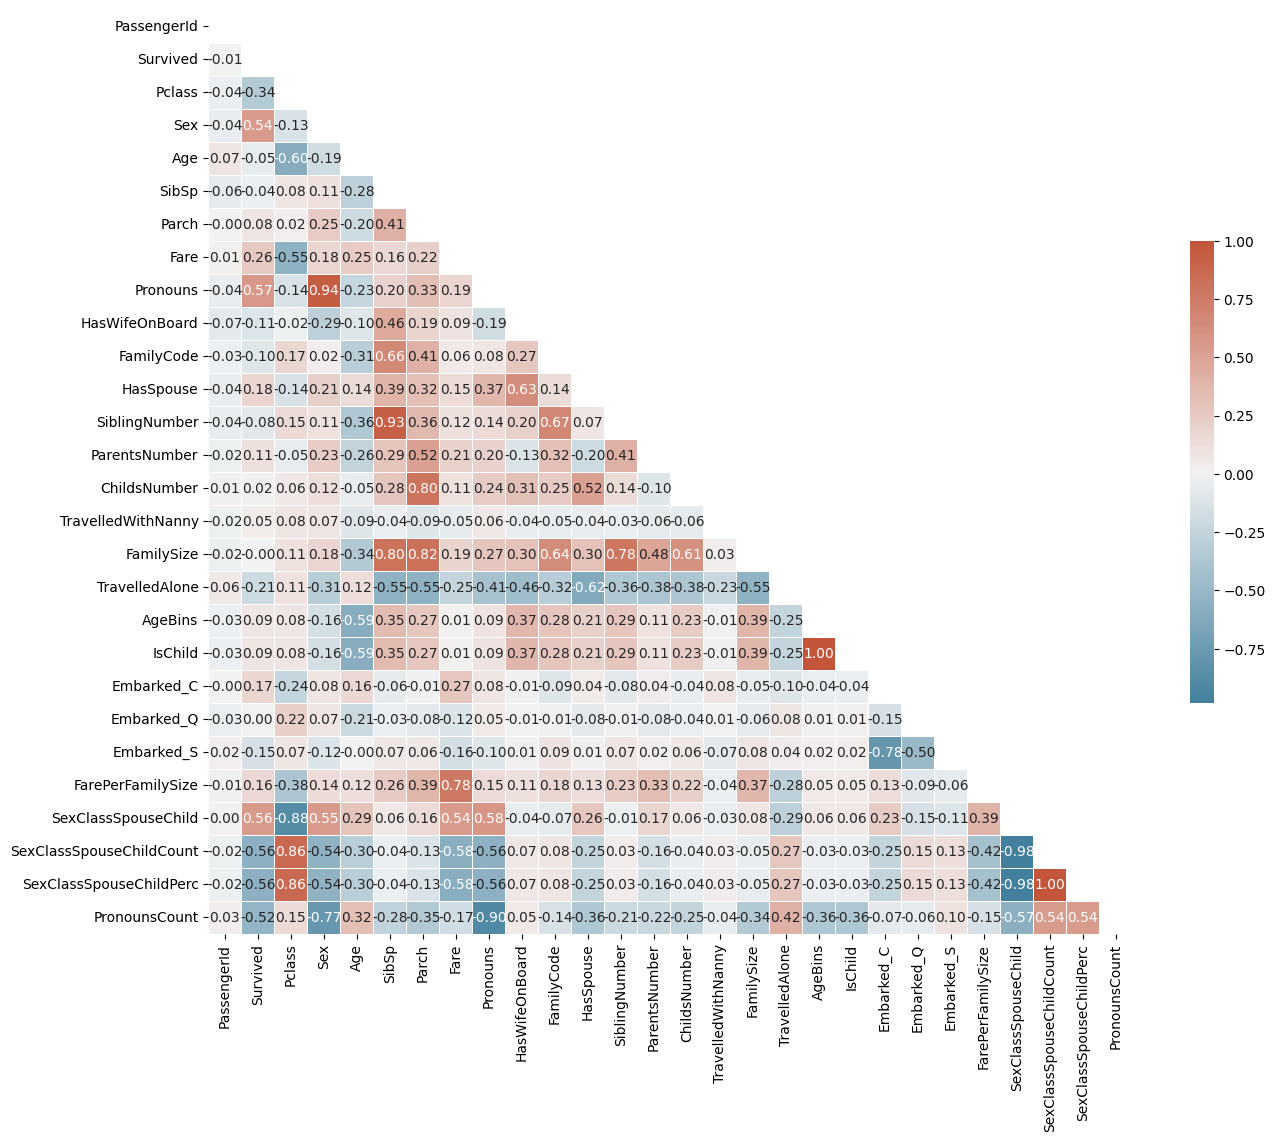

In [66]:
plot_heatmap(df[df.select_dtypes(include=['number']).columns].corr())

In [67]:
# multicolinear_features.append('SibSp')          # SiblingNumber, FamilySize
# multicolinear_features.append('Parch')          # ChildNumber
# multicolinear_features.append('SiblingNumber')  # FamilySize
# multicolinear_features.append('Pclass')         # SexSpouseChildCound, SexClassSpouseChildPerc
# multicolinear_features.append('Sex')

## Feature Importances

In [68]:
def set_feature_importance(X_train, y_train, clf, num_features: int = 20):
    
    # Treinando o modelo e obtendo as importâncias das features
    clf.fit(X_train, y_train)
    importances = clf.feature_importances_
    
    feature_names = X_train.columns
    indices = np.argsort(importances)[::-1]  # Ordena as importâncias em ordem decrescente

    # Preparando a lista de features mais importantes
    feature_importance = feature_names[indices][:num_features].to_list()
    
    global feature_importance_cols
    feature_importance_cols = feature_importance

    # # Plotando o gráfico de importâncias das features
    # plt.figure(figsize=(15, 6))
    # plt.title("Feature Importances")
    # bars = plt.bar(range(num_features), importances[indices][:num_features], color="r", align="center")
    # plt.xticks(range(num_features), feature_names[indices][:num_features], rotation=90)
    # plt.xlim([-1, num_features])
    # plt.tight_layout()
    
    # # Adicionando a pontuação de importância como anotações nas barras
    # for bar, importance in zip(bars, importances[indices][:num_features]):
    #     plt.text(
    #         bar.get_x() + bar.get_width() / 2,
    #         bar.get_height(),
    #         f'{importance:.4f}',  # Formato da pontuação com 4 casas decimais
    #         ha='center',
    #         va='bottom',
    #         fontsize=10
    #     )
    
    # plt.show()

In [69]:
df, test = get_processed_dataframes(get_train_and_test_dataframes())

cols_to_predict = df[df.select_dtypes(include=['number']).columns].columns.to_list()
cols_to_predict.remove('PassengerId')
cols_to_predict.remove('Survived')

# for feature in multicolinear_features:
#     if feature in cols_to_predict:
#         cols_to_predict.remove(feature)

Xtrain = df[cols_to_predict]
ytrain = df.Survived

In [70]:
set_feature_importance(X_train=Xtrain, y_train=ytrain, num_features=19, clf=GradientBoostingClassifier())

## Crossval

In [71]:
# Modelos sem necessidade de padronização
non_scaled_models = [
    ('XGBClassifier', XGBClassifier(verbosity=0, objective='binary:hinge')), 
    ('GradientBoostingClassifier', GradientBoostingClassifier(n_estimators=63, learning_rate=0.099)),
    ('LGBMClassifier', LGBMClassifier(verbosity=-1)),  
    ('RandomForestClassifier', RandomForestClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('ExtraTreesClassifier', ExtraTreesClassifier()),
    ('HistGradientBoostingClassifier', HistGradientBoostingClassifier()),
    ('RidgeClassifier', RidgeClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('GaussianNB', GaussianNB())
]

# Modelos que precisam de padronização
scaled_models = [
    ('LogisticRegression', LogisticRegression()),
    ('SGDClassifier', SGDClassifier()),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('SVC', SVC()),
    ('MLPClassifier', MLPClassifier(max_iter=1000))
]

# Aplicando o Pipeline com StandardScaler apenas aos modelos sensíveis à escala
pipelines = [
    (name, Pipeline([('scaler', StandardScaler()), ('classifier', model)])) 
    for name, model in scaled_models
]

all_models = non_scaled_models + pipelines

In [72]:
def avaliar_pelo_gabarito(ypred) -> float:
    gabarito_df = pd.read_csv("C:/Users/clayt/Projetos/IDP/ml-01/dados/titanic/gabarito.csv")
    score = accuracy_score(y_pred=ypred, y_true=gabarito_df.Survived)
    return round(score, 5)

In [73]:
from sklearn.model_selection import KFold

def avaliar_modelos(modelos, X, y, n_splits=10, metric='accuracy'):
    resultados = {}
    
    # KFold sem estratificação
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for nome, modelo in modelos:
        scores = []
        
        # Realizar a validação cruzada sem estratificação
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
            scores.append(accuracy_score(y_test, y_pred))
        
        resultados[nome] = {
            'media': np.mean(scores),
            'desvio_padrao': np.std(scores)
        }
    
    return resultados


In [74]:
resultados = avaliar_modelos(all_models, Xtrain, ytrain, n_splits=5, metric='accuracy')
for nome, resultado in resultados.items():
    print(f"{nome}: Média = {resultado['media']:.5f}, Desvio Padrão = {resultado['desvio_padrao']:.4f}")

XGBClassifier: Média = 0.81368, Desvio Padrão = 0.0180
GradientBoostingClassifier: Média = 0.82717, Desvio Padrão = 0.0167
LGBMClassifier: Média = 0.82044, Desvio Padrão = 0.0229
RandomForestClassifier: Média = 0.80696, Desvio Padrão = 0.0115
AdaBoostClassifier: Média = 0.82493, Desvio Padrão = 0.0207
ExtraTreesClassifier: Média = 0.79911, Desvio Padrão = 0.0241
HistGradientBoostingClassifier: Média = 0.82155, Desvio Padrão = 0.0208
RidgeClassifier: Média = 0.82269, Desvio Padrão = 0.0271
DecisionTreeClassifier: Média = 0.80584, Desvio Padrão = 0.0190
GaussianNB: Média = 0.79126, Desvio Padrão = 0.0154
LogisticRegression: Média = 0.81706, Desvio Padrão = 0.0203
SGDClassifier: Média = 0.77111, Desvio Padrão = 0.0510
KNeighborsClassifier: Média = 0.80132, Desvio Padrão = 0.0186
SVC: Média = 0.82605, Desvio Padrão = 0.0243
MLPClassifier: Média = 0.79461, Desvio Padrão = 0.0248


In [75]:
scores = []
d = {'models': [], 'score': []}

for model in all_models:
    clf = model[1]
    clf.fit(Xtrain[cols_to_predict], ytrain)
    ypred = clf.predict(test[cols_to_predict])
    score = avaliar_pelo_gabarito(ypred)
    
    d['models'].append(model[0])
    d['score'].append(score)

df_score = pd.DataFrame.from_dict(d)
df_score.sort_values(by=['score'], ascending=[False], inplace=True)
df_score

,models,score
1,GradientBoostingClassifier,0.78469
4,AdaBoostClassifier,0.78230
7,RidgeClassifier,0.77273
10,LogisticRegression,0.76794
13,SVC,0.76555
11,SGDClassifier,0.75359
14,MLPClassifier,0.75359
12,KNeighborsClassifier,0.75120
5,ExtraTreesClassifier,0.74880
0,XGBClassifier,0.74641


## Tunning

### GradientBoosting

In [76]:
df, test = get_processed_dataframes(get_train_and_test_dataframes())

cols_to_predict = df[df.select_dtypes(include=['number']).columns].columns.to_list()
cols_to_predict.remove('PassengerId')
cols_to_predict.remove('Survived')

# for feature in multicolinear_features:
#     if feature in cols_to_predict:
#         cols_to_predict.remove(feature)

Xtrain = df[cols_to_predict]
ytrain = df.Survived

In [77]:
# sem ohe de pronouns
features_gradient_boosting01 = [
    'Sex',
    'FarePerFamilySize',
    'Fare',
    'SexClassSpouseChild',
    'SexClassSpouseChildPerc',
    'IsChild',
    'SexClassSpouseChildCount',
    'Pclass',
    'SiblingNumber',
    'AgeBins',
    'FamilySize',
    'Embarked',
    'Age',
    'SibSp',
    'TravelledAlone'
]

# one hot encoding de pronouns
features_gradient_boosting02 = [
    'Pronouns_1.0',
    'FarePerFamilySize',
    'Fare',
    'SexClassSpouseChild',
    'Sex',
    'Age',
    'SexClassSpouseChildPerc',
    'SexClassSpouseChildCount',
    'Embarked',
    'FamilySize',
    'SiblingNumber',
    'Pronouns_3.0'
]

In [78]:
set_feature_importance(X_train=Xtrain, y_train=ytrain, clf=GradientBoostingClassifier(), num_features=13)

In [79]:
for i in range(3, 24):
    set_feature_importance(X_train=Xtrain, y_train=ytrain, clf=GradientBoostingClassifier(), num_features=i)
    clf = GradientBoostingClassifier()
    clf.fit(Xtrain[feature_importance_cols], ytrain)
    ypred = clf.predict(test[feature_importance_cols])
    score = avaliar_pelo_gabarito(ypred)
    print(score, feature_importance_cols)

0.75598 ['Pronouns_1.0', 'FarePerFamilySize', 'Fare']
0.77512 ['Pronouns_1.0', 'FarePerFamilySize', 'Fare', 'SexClassSpouseChild']
0.7823 ['Pronouns_1.0', 'FarePerFamilySize', 'SexClassSpouseChild', 'Fare', 'Sex']
0.7823 ['Pronouns_1.0', 'FarePerFamilySize', 'SexClassSpouseChild', 'Fare', 'SexClassSpouseChildPerc', 'Sex']
0.77751 ['Pronouns_1.0', 'FarePerFamilySize', 'Fare', 'SexClassSpouseChild', 'SexClassSpouseChildPerc', 'Sex', 'Age']
0.76316 ['Pronouns_1.0', 'FarePerFamilySize', 'SexClassSpouseChild', 'Fare', 'SexClassSpouseChildPerc', 'Sex', 'Age', 'FamilyCode']
0.76316 ['Pronouns_1.0', 'FarePerFamilySize', 'Fare', 'SexClassSpouseChild', 'SexClassSpouseChildPerc', 'Sex', 'Age', 'SexClassSpouseChildCount', 'FamilyCode']
0.77273 ['Pronouns_1.0', 'FarePerFamilySize', 'Fare', 'SexClassSpouseChild', 'SexClassSpouseChildPerc', 'Sex', 'Age', 'FamilyCode', 'Embarked', 'SexClassSpouseChildCount']
0.78469 ['Pronouns_1.0', 'FarePerFamilySize', 'Fare', 'SexClassSpouseChild', 'SexClassSpouseCh

In [80]:
features_gradientboosting = ['Pronouns_1.0', 'FarePerFamilySize', 'Fare', 'SexClassSpouseChild', 'SexClassSpouseChildPerc', 'Sex', 'Age', 'SexClassSpouseChildCount', 'FamilyCode', 'Embarked', 'SibSp', 'FamilySize']


### XGBClassifier

In [81]:
df, test = get_processed_dataframes(get_train_and_test_dataframes())

cols_to_predict = df[df.select_dtypes(include=['number']).columns].columns.to_list()
cols_to_predict.remove('PassengerId')
cols_to_predict.remove('Survived')

# for feature in multicolinear_features:
#     if feature in cols_to_predict:
#         cols_to_predict.remove(feature)

Xtrain = df[cols_to_predict]
ytrain = df.Survived

In [82]:
set_feature_importance(X_train=Xtrain, y_train=ytrain, clf=XGBClassifier(), num_features=2)

In [83]:
features_xgb = [
    'Pronouns_1.0',
    'SexClassSpouseChild'
]

In [84]:
clf = XGBClassifier(objective='binary:hinge')
clf.fit(Xtrain[features_xgb], ytrain)
ypred = clf.predict(test[features_xgb])
score = avaliar_pelo_gabarito(ypred)
score

0.78708

### LGBM

In [85]:
df, test = get_processed_dataframes(get_train_and_test_dataframes())

cols_to_predict = df[df.select_dtypes(include=['number']).columns].columns.to_list()
cols_to_predict.remove('PassengerId')
cols_to_predict.remove('Survived')

# for feature in multicolinear_features:
#     if feature in cols_to_predict:
#         cols_to_predict.remove(feature)

Xtrain = df[cols_to_predict]
ytrain = df.Survived

In [86]:
set_feature_importance(X_train=Xtrain, y_train=ytrain, clf=LGBMClassifier(verbosity=-1), num_features=8)
clf = LGBMClassifier(verbosity=-1)
clf.fit(Xtrain[feature_importance_cols], ytrain)
ypred = clf.predict(test[feature_importance_cols])
score = avaliar_pelo_gabarito(ypred)
score

0.76077

In [87]:
feature_importance_cols

['Fare',
 'FarePerFamilySize',
 'FamilyCode',
 'Embarked',
 'Age',
 'FamilySize',
 'Sex',
 'Pronouns_1.0']

In [88]:
features_lgbm = [
    'Fare',
    'FarePerFamilySize',
    'Embarked',
    'Age',
    'FamilySize',
    'Sex',
    'SibSp',
    'SexClassSpouseChild'
]

### RandomForest

In [89]:
df, test = get_processed_dataframes(get_train_and_test_dataframes())

cols_to_predict = df[df.select_dtypes(include=['number']).columns].columns.to_list()
cols_to_predict.remove('PassengerId')
cols_to_predict.remove('Survived')

Xtrain = df[cols_to_predict]
ytrain = df.Survived

In [90]:
set_feature_importance(X_train=Xtrain, y_train=ytrain, clf=RandomForestClassifier(), num_features=7)
feature_importance_cols

['FarePerFamilySize',
 'Fare',
 'Pronouns_1.0',
 'Sex',
 'SexClassSpouseChild',
 'SexClassSpouseChildCount',
 'FamilyCode']

In [91]:
features_randomforest = [
    'FarePerFamilySize',
    'Fare',
    'Sex',
    'Pronouns_1.0',
    'SexClassSpouseChildPerc',
    'SexClassSpouseChild',
    'SexClassSpouseChildCount'
 ]

In [92]:
for i in range(2, 26):
    set_feature_importance(X_train=Xtrain, y_train=ytrain, clf=RandomForestClassifier(), num_features=i)

    clf = RandomForestClassifier()
    clf.fit(Xtrain[feature_importance_cols], ytrain)
    ypred = clf.predict(test[feature_importance_cols])
    score = avaliar_pelo_gabarito(ypred)
    print(score, i)

0.689 2
0.75359 3
0.77512 4
0.72967 5
0.75598 6
0.76077 7
0.7512 8
0.76077 9
0.75359 10
0.75598 11
0.76794 12
0.7512 13
0.74163 14
0.7512 15
0.74402 16
0.74163 17
0.73923 18
0.73684 19
0.74402 20
0.73684 21
0.72488 22
0.72727 23
0.73923 24
0.73206 25


In [93]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Função de objetivo para o Optuna
def objective(trial):
    # Definir os hiperparâmetros que serão otimizados
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Criar o modelo RandomForestClassifier com os hiperparâmetros sugeridos
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    # Usar validação cruzada para avaliar o desempenho
    score = cross_val_score(clf, Xtrain[features_randomforest], ytrain, cv=5, scoring='accuracy').mean()
    
    return score

# Criar a study e realizar a otimização
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=120)

# # Exibir os melhores hiperparâmetros
# print("Best hyperparameters:", study.best_params)

# # Treinar o RandomForestClassifier com os melhores hiperparâmetros
# best_params = study.best_params
# best_clf = RandomForestClassifier(**best_params, random_state=42)
# best_clf.fit(Xtrain[features_randomforest], ytrain)

# # Realizar previsões
# pred = best_clf.predict(test[features_randomforest])
# avaliar_pelo_gabarito(ypred=pred)

### AdaBoostClassifier

In [94]:
df, test = get_processed_dataframes(get_train_and_test_dataframes())

cols_to_predict = df[df.select_dtypes(include=['number']).columns].columns.to_list()
cols_to_predict.remove('PassengerId')
cols_to_predict.remove('Survived')

Xtrain = df[cols_to_predict]
ytrain = df.Survived

In [95]:
# for i in range(2, 26):
#     set_feature_importance(X_train=Xtrain, y_train=ytrain, clf=AdaBoostClassifier(), num_features=i)

#     clf = AdaBoostClassifier()
#     clf.fit(Xtrain[feature_importance_cols], ytrain)
#     ypred = clf.predict(test[feature_importance_cols])
#     score = avaliar_pelo_gabarito(ypred)
#     print(score, i)

In [96]:
set_feature_importance(X_train=Xtrain, y_train=ytrain, clf=AdaBoostClassifier(), num_features=12)
feature_importance_cols

['FamilySize',
 'Pronouns_2.0',
 'Pronouns_1.0',
 'SexClassSpouseChildPerc',
 'Fare',
 'FarePerFamilySize',
 'SexClassSpouseChild',
 'Embarked',
 'Age',
 'Pronouns_4.0',
 'Pronouns_5.0',
 'Pronouns_Dona']

In [97]:
features_adaboost = [
    'FarePerFamilySize',
    'Fare',
    'FamilySize',
    'Age',
    'SexClassSpouseChild',
    'Pronouns_2.0',
    'Pronouns_5.0',
    'SibSp',
    'Embarked',
    'SiblingNumber',
    'Pclass',
    'Pronouns_1.0'
]

In [98]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Função de objetivo para o Optuna
def objective(trial):
    # Hiperparâmetros que serão otimizados
    n_estimators = trial.suggest_int('n_estimators', 50, 500)  # Normalmente entre 50 e 500
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)  # Pequenos valores reduzem o overfitting
    max_depth = trial.suggest_int('max_depth', 1, 10)  # Para o base_estimator DecisionTreeClassifier

    # Estimador base (árvore de decisão) com profundidade máxima otimizada
    estimator = DecisionTreeClassifier(max_depth=max_depth)

    # Criar o modelo AdaBoostClassifier com os hiperparâmetros sugeridos
    clf = AdaBoostClassifier(
        estimator=estimator,  # Ajuste aqui
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    # Usar validação cruzada para avaliar o desempenho
    score = cross_val_score(clf, Xtrain[features_adaboost], ytrain, cv=5, scoring='accuracy').mean()

    return score

# Criar a study e realizar a otimização
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=120)

# # Exibir os melhores hiperparâmetros
# print("Best hyperparameters:", study.best_params)

# # Treinar o AdaBoostClassifier com os melhores hiperparâmetros
# best_params = study.best_params
# best_estimator = DecisionTreeClassifier(max_depth=best_params.pop('max_depth'))
# best_clf = AdaBoostClassifier(estimator=best_estimator, **best_params, random_state=42)
# best_clf.fit(Xtrain[features_adaboost], ytrain)

# # Realizar previsões
# pred = best_clf.predict(test[features_adaboost])
# avaliar_pelo_gabarito(ypred=pred)

In [99]:
# inicial_score = 0.76555

# estimator = DecisionTreeClassifier(max_depth=4)

# for i in range(0, 250):
#     adaboost_hiperparams = {'n_estimators': 109, 'learning_rate': 0.015526428169241834, 'random_state': i}
#     clf = AdaBoostClassifier(**adaboost_hiperparams)
#     clf.fit(Xtrain[features_adaboost], ytrain)
#     ypred = clf.predict(test[features_adaboost])
#     score = avaliar_pelo_gabarito(ypred=ypred)
#     if score > inicial_score:
#         print(score, i)
#         inicial_score = score

### MLPClassifier

In [100]:
df, test = get_processed_dataframes(get_train_and_test_dataframes())

cols_to_predict = df[df.select_dtypes(include=['number']).columns].columns.to_list()
cols_to_predict.remove('PassengerId')
cols_to_predict.remove('Survived')

Xtrain = df[cols_to_predict]
ytrain = df.Survived

In [101]:
# from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.neural_network import MLPClassifier


# mlp = Pipeline([('scaler', StandardScaler()), ('classifier', MLPClassifier())])

# # Sequential Forward Selection
# sfs = SequentialFeatureSelector(mlp, n_features_to_select=13, direction='forward')

# # Ajuste
# sfs.fit(Xtrain, ytrain)

# # Features selecionadas
# print(f"Features selecionadas para {13} features:", Xtrain.columns[sfs.get_support()])

Features selecionadas para 2 features: Index(['Sex', 'SiblingNumber'], dtype='object')
Features selecionadas para 3 features: Index(['Sex', 'Age', 'SiblingNumber'], dtype='object')
Features selecionadas para 4 features: Index(['Sex', 'Age', 'SiblingNumber', 'ChildsNumber'], dtype='object')
Features selecionadas para 5 features: Index(['Sex', 'Age', 'SiblingNumber', 'ChildsNumber', 'Pronouns_5.0'], dtype='object')
Features selecionadas para 6 features: Index(['Sex', 'Age', 'SiblingNumber', 'ChildsNumber', 'SexClassSpouseChild', 'Pronouns_5.0'], dtype='object')
Features selecionadas para 7 features: Index(['Sex', 'Age', 'Embarked', 'SiblingNumber', 'ChildsNumber', 'SexClassSpouseChild', 'Pronouns_5.0'], dtype='object')
Features selecionadas para 8 features: Index(['Sex', 'Age', 'Embarked', 'HasSpouse', 'SiblingNumber', 'ChildsNumber', 'SexClassSpouseChild', 'Pronouns_5.0'], dtype='object')

Features selecionadas para 9 features: Index(['Sex', 'Age', 'Embarked', 'HasSpouse', 'SiblingNumber', 'ChildsNumber', 'SexClassSpouseChild', 'Pronouns_4.0', 'Pronouns_5.0'], dtype='object')

Features selecionadas para 10 features: Index(['Sex', 'Age', 'Embarked', 'HasSpouse', 'SiblingNumber', 'ParentsNumber', 'ChildsNumber', 'SexClassSpouseChild', 'Pronouns_4.0', 'Pronouns_5.0'], dtype='object')


In [102]:
features_mlp01 = [ 'Sex', 'Age', 'Embarked', 'HasSpouse', 'SiblingNumber', 'ParentsNumber', 'ChildsNumber', 'SexClassSpouseChild', 'Pronouns_4.0', 'Pronouns_5.0']
features_mlp02 = ['Pclass', 'Sex', 'Age', 'Embarked', 'HasSpouse', 'SiblingNumber', 'ParentsNumber', 'ChildsNumber', 'IsChild', 'SexClassSpouseChild', 'Pronouns_4.0', 'Pronouns_5.0']
features_mlp03 = ['Pclass', 'Sex', 'Embarked', 'SiblingNumber', 'ParentsNumber',
       'ChildsNumber', 'TravelledWithNanny', 'IsChild', 'AgeBins',
       'SexClassSpouseChild', 'SexClassSpouseChildPerc', 'FarePerFamilySize',
       'Pronouns_3.0']

In [103]:
clf = Pipeline([('scaler', StandardScaler()), ('classifier', MLPClassifier(max_iter=1000))])
clf.fit(Xtrain[features_mlp03], ytrain)
ypred = clf.predict(test[features_mlp03])
avaliar_pelo_gabarito(ypred)

0.77751

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Definição do pipeline
clf = Pipeline([
    ('scaler', StandardScaler()),               # Etapa de normalização
    ('mlp', MLPClassifier(max_iter=1000))       # Classificador MLP
])

# Ajustar o pipeline
clf.fit(Xtrain[features_mlp03], ytrain)

# Fazer predições
ypred = clf.predict(test[features_mlp03])

# Avaliação das predições
avaliar_pelo_gabarito(ypred)


0.77273

## Ensamble

In [105]:
features_gradient_boosting02 = [
    'Pronouns_1.0',
    'FarePerFamilySize',
    'Fare',
    'SexClassSpouseChild',
    'Sex',
    'Age',
    'SexClassSpouseChildPerc',
    'SexClassSpouseChildCount',
    'Embarked',
    'FamilySize',
    'SiblingNumber',
    'Pronouns_3.0'
]

features_xgb = [
    'Pronouns_1.0',
    'SexClassSpouseChild'
]

features_lgbm = [
    'Fare',
    'FarePerFamilySize',
    'Embarked',
    'Age',
    'FamilySize',
    'Sex',
    'SibSp',
    'SexClassSpouseChild'
]

features_randomforest = [
    'FarePerFamilySize',
    'Fare',
    'Sex',
    'Pronouns_1.0',
    'SexClassSpouseChildPerc',
    'SexClassSpouseChild',
    'SexClassSpouseChildCount'
 ]

features_adaboost = [
    'FarePerFamilySize',
    'Fare',
    'FamilySize',
    'Age',
    'SexClassSpouseChild',
    'Pronouns_2.0',
    'Pronouns_5.0',
    'SibSp',
    'Embarked',
    'SiblingNumber',
    'Pclass',
    'Pronouns_1.0'
]

In [106]:
randomforest_hiperparams = {'n_estimators': 153, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'random_state': 134}
adaboost_hiperparams = {'n_estimators': 109, 'learning_rate': 0.015526428169241834, 'random_state': 0}

In [107]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from sklearn.kernel_ridge import KernelRidge

# Definição das transformações para seleção de features
gbc_transformer = ColumnTransformer(transformers=[('selector', 'passthrough', features_gradient_boosting02)], remainder='drop')
rfc_transformer = ColumnTransformer(transformers=[('selector', 'passthrough', features_randomforest)], remainder='drop')
ridge_transformer = ColumnTransformer(transformers=[('selector', 'passthrough', features_gradient_boosting01)], remainder='drop')
mlp_transformer = ColumnTransformer(transformers=[('selector', 'passthrough', features_mlp01)], remainder='drop')
lgbm_transformer = ColumnTransformer(transformers=[('selector', 'passthrough', features_lgbm)], remainder='drop')
sgd_transformer = ColumnTransformer(transformers=[('selector', 'passthrough', features_gradient_boosting01)], remainder='drop')

ada_transformer = ColumnTransformer(transformers=[('selector', 'passthrough', features_adaboost)], remainder='drop')
lgbm_transformer = ColumnTransformer(transformers=[('selector', 'passthrough', features_lgbm)], remainder='drop')
gnb_transformer = ColumnTransformer(transformers=[('selector', 'passthrough', features_xgb)], remainder='drop')
svm_transformer = ColumnTransformer(transformers=[('selector', 'passthrough', cols_to_predict)], remainder='drop')

# Criar os pipelines com a seleção de features e escalamento onde necessário
estimators = [
    ('gbc', make_pipeline(gbc_transformer, GradientBoostingClassifier())),
    ('rfc01', make_pipeline(rfc_transformer, RandomForestClassifier(**randomforest_hiperparams))),
    ('lgbm', make_pipeline(lgbm_transformer, LGBMClassifier(verbose=-1))),
    ('ridge', make_pipeline(ridge_transformer, RidgeClassifier())),
    ('sgd', make_pipeline(sgd_transformer, KernelRidge())), 
    # ('mlp', make_pipeline(mlp_transformer, StandardScaler(), MLPClassifier(max_iter=1000))),
    # ('adaboost', make_pipeline(ada_transformer, AdaBoostClassifier(**adaboost_hiperparams))),
    # ('svr', make_pipeline(svm_transformer, StandardScaler(), LinearSVC(random_state=42))),
    # ('xgb', make_pipeline(xgb_transformer, XGBClassifier())),
    # ('gnb', make_pipeline(svm_transformer, StandardScaler(), GaussianNB())),  
]


# Stacking Classifier com o RidgeClassifier como final_estimator
stacking = StackingClassifier(
    cv=5,
    estimators=estimators,
    final_estimator=RidgeClassifier()
)

# Treinar o Stacking com os dados de treino
stacking.fit(Xtrain, ytrain)

# Fazer previsões no conjunto de teste
ypred = stacking.predict(test[cols_to_predict])

# Avaliação das predições
avaliar_pelo_gabarito(ypred=ypred)

0.79426

## Submit

In [108]:
d = {
    'PassengerId': test.PassengerId,
    'Survived': ypred.astype(int)
}

submit_prediction = pd.DataFrame.from_dict(d)
submit_prediction.to_csv('submission.csv', index=False)

In [109]:
submit_prediction.head()

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
